## Importing Libraries

In [1]:
import mtcnn
import numpy as np
import pandas as pd 
import cv2 
from mtcnn import MTCNN 
import matplotlib.pyplot as plt 
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice
from PIL import Image 
import os 
print(os.listdir("input"))

['.ipynb_checkpoints', 'data', 'train', 'val']


## Sample Images 

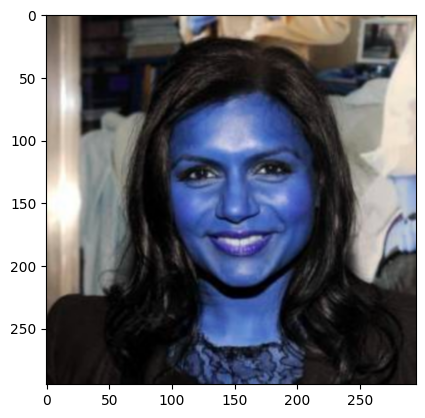

(295, 295, 3)


In [2]:
img = cv2.imread('input/data/train/mindy_kaling/httpgonetworthcomwpcontentuploadsthumbsjpg.jpg')
plt.imshow(img, cmap = 'Dark2', interpolation = 'bicubic')
plt.show()
print(img.shape)

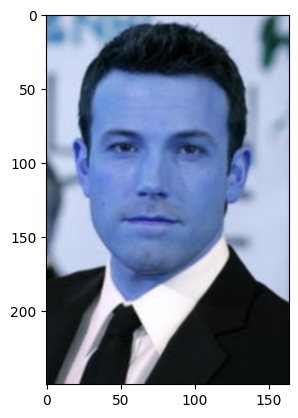

(250, 164, 3)


In [3]:
img = cv2.imread('input/data/train/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg')
plt.imshow(img, cmap = 'Dark2', interpolation = 'bicubic')
plt.show()
print(img.shape)

### Extracting face, Loading Face and Loading Dataset

In [4]:
def extract_face(filename, required_size=(160,160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1+width, y1+height
    face = pixels[y1:y2, x1:x2]
    image =  Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array
    

In [5]:
def load_face(dir):
    faces = list()
    for filename in os.listdir(dir):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(dir, filename)
        face = extract_face(path)
        faces.append(face)
    return faces


In [6]:
def load_dataset(dir):
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = os.path.join(dir,subdir)
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir))
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

trainX, trainy = load_dataset('input/data/train')
print(trainX.shape, trainy.shape)
testX, testy = load_dataset("input/data/val")
print(testX.shape, testy.shape)
np.savez_compressed("5-celebrity-faces-dataset.npz", trainX, trainy, testX, testy) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1

### Train Test Split

In [7]:
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


### Standardizing the faces and extracting a embedding vector using the  SVC model

In [8]:
from keras_facenet import FaceNet
facenet_model = FaceNet()

In [9]:
def get_embedding(model, face):
    # Scale pixel values
    face = face.astype('float32')
    sample = np.expand_dims(face, axis=0)
    yhat = model.embeddings(sample)
    return yhat[0]

emdTrainX = []
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
emdTrainX = np.asarray(emdTrainX)
print("Training embeddings shape:", emdTrainX.shape)

emdTestX = []
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print("Test embeddings shape:", emdTestX.shape)
np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX=emdTrainX, trainy=trainy, emdTestX=emdTestX, testy=testy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [10]:
data = np.load('5-celebrity-faces-embeddings.npz')
emdTrainX = data['emdTrainX']
trainy = data['trainy']
print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
in_encoder = Normalizer()

emdTrainX_norm = in_encoder.fit_transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)

out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)

model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)

score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)

print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))


Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


### Randomly Select a face from test set for prediction. Calculating probability

Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[86.67184973  4.50147192  2.36862533  2.39398855  4.06406447]
Expected: ben_afflek


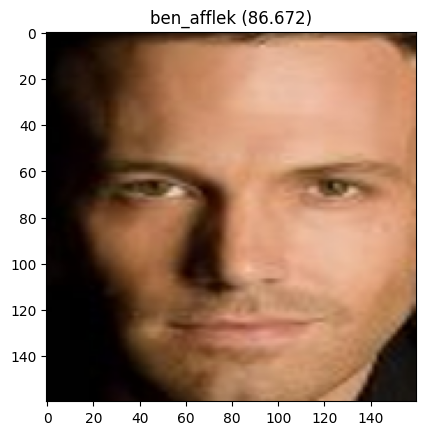

In [11]:
selection = choice([i for i in range(testX.shape[0])])

random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

samples = np.expand_dims(random_face_emd, axis=0)

yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100

predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])

print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])

plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()